# Predicting Water Quality: Safe or Not Safe for Consumption  #

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWgyMTlmdjk3aHFjejM0ZGp1ZjhlYnBjbGIwbjM2NGN4MnV0eTdvYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/S1N2zUokK7jiM/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWgyMTlmdjk3aHFjejM0ZGp1ZjhlYnBjbGIwbjM2NGN4MnV0eTdvYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/S1N2zUokK7jiM/giphy.gif

## 1. Introduction: ##

### Why is water safety an important topic? ###

Water is an essential nutrient to all who call Earth their home, and access to safe drinking water is a component of effective policy for health protection, preventing the spread of infectious diseases. According to the World Health Organization (2023), in 2022 alone, “115 million people collect[ed] untreated surface water from lakes, ponds, rivers and streams.” As such, these waters are far more prone to contaminants that may strike people with intense illnesses, like cholera, diarrhoea, dysentery, hepatitis A, typhoid and polio. Given that these unsafe water put hundreds of millions of people worldwide at risk, water safety is a serious health and development issue at a national, regional, and local level (World Health Organization, 2023).

### Background Information & Our Question ###

Given how large of a concern water safety is, we ask the question: **can we construct a model that predicts and classifies whether a sample of water is safe to consume or not, given a set of contaminant levels?** In our exploration of this question, the predictors we will be using are the most common contaminants water tends to carry, which includes arsenic, bacteria, lead, nitrates, nitrites, and viruses (United States Environmental Protection Agency, 2015).

### Dataset Being Used ###

The dataset we are using was found on Kaggle (https://www.kaggle.com/datasets/mssmartypants/water-quality), and it provides information on different contaminants in water and their maximum concentration allowed to be present for water to remain safe to use, with nearly 8000 observations. It contains 20 predictor variables (contaminant levels within water), and one binary response variable (whether or not the water is safe to drink).23).

## 2. Preliminary exploratory data analysis ##

As seen below, we can load the dataset using the read_csv function, given that it a .csv file. To load in the dataset, we are using a GitHub raw URL (which links to the dataset we downloaded from Kaggle and added into our github repository) to load it in.

In [1]:
library(tidyverse)
library(tidymodels)
url <- "https://raw.githubusercontent.com/zayan-sheikh/DSCI-G13-Project/main/data/waterQuality1.csv"
raw_data <- read_csv(url) |>
            mutate(is_safe = as_factor(is_safe))|>
            mutate(is_safe = fct_recode(is_safe, 'safe' = '1', 'not safe' = '0')) |>
            select(arsenic, bacteria, viruses, lead, nitrates, nitrites, is_safe)

head(raw_data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.04,0.20,0.000,0.054,16.08,1.13,safe
0.01,0.65,0.650,0.100,2.01,1.93,safe
0.04,0.05,0.003,0.078,14.16,1.11,not safe
0.04,0.71,0.710,0.016,1.41,1.29,safe
0.03,0.13,0.001,0.117,6.74,1.11,safe
0.03,0.67,0.670,0.135,9.75,1.89,safe


*This is a glimpse at the first 6 rows of our dataset. There are 20 variables and one class variable which will be used as our predicting class. As mentioned, we will limit our predictor variables to the 6 most common contaminants. Our prediction will be based on the amount of different materials in water samples which will be used to predict if water is safe or not.*

**NOTE:** This data is already tidy, as each column denotes a variable (Either contaminant level or water safety), each row denotes an observation, and each cell denotes a value.

In the cell below, we will split our data into training data, and testing data.

In [2]:
water_split <- initial_split(raw_data, prop = 0.75, strata = is_safe)
water_train <- training(water_split)
water_test <- testing(water_split)

Now, it would be useful to summarize this data to get a sense of its distribution. One way to do this would be to find the mean of each predictor variable, and also the proportion of safe to unsafe water, as shown below:

In [39]:
water_wrangled <- water_train |>
                    pivot_longer(cols = arsenic:nitrites, names_to = "contaminant", values_to = "level")

water_means <- water_wrangled |> 
                     na.omit() |>
                     group_by(contaminant)|>
                     summarize(average_value = mean(level))

water_means

# Manipulating data to get number of observations for each class
water_train_table <- water_train |> 
                     na.omit() |>
                     group_by(is_safe)|>
                     summarize(count = n())

water_train_table


contaminant,average_value
<chr>,<dbl>
arsenic,0.1615661
bacteria,0.3189762
lead,0.0997914
nitrates,9.8497015
nitrites,1.3303769
viruses,0.3249838


is_safe,count
<fct>,<int>
not safe,5313
safe,684


We now have a sense of the average values for each predictor variable we are using, as well as the distribution of our response variable.

Now, for a deeper understanding of our dataset, we can visually interpret the distribution of each predictor variable, as done below:

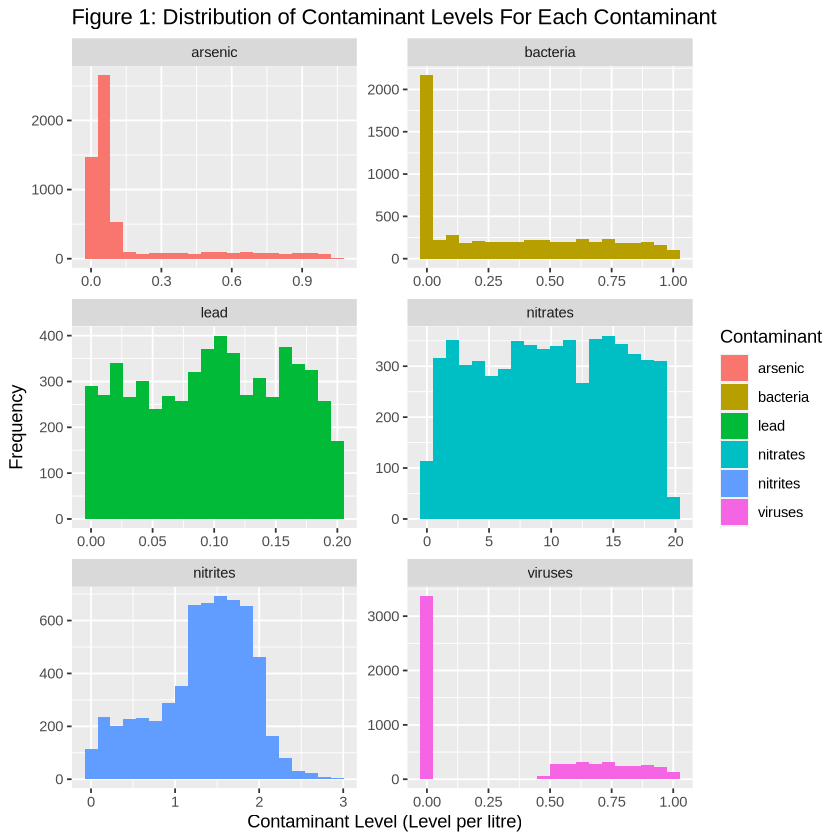

In [46]:
water_train_plot <- water_wrangled |>
                    ggplot(aes(x=level, fill = contaminant)) +
                    geom_histogram(bins = 20) +
                    facet_wrap(vars(contaminant), scales = "free", nrow = 3) +
                    labs(x=" Contaminant Level (Level per litre)", y="Frequency", fill="Contaminant") +
                    ggtitle("Figure 1: Distribution of Contaminant Levels For Each Contaminant")

water_train_plot

*Figure 1 showcases one of many plots that can describe our situation. In this case, it shows the distribution of the various levels for each contaminant. The plotted histogram gives us a rough idea about the data we're working with; For instance, we can deduce that lead and nitrates have rather even distributions, whilst arsenic, bacteria, and viruses tend to have lower values in our dataset.*

***NOTE:*** *Each plot is on a different scale for readability, and was plotted using only the training data set.*

## 3. Methods ##

### Conducting our Data Analysis ###

To carry out this data analysis, we will be employing the k-nearest neighbors classification algorithm. This involves using the data on each existing observation's predictor values and whether or not the sample is safe to consume or not, and then using this data to "train our model," such that we can classify a new observation that only contains predictors, but is not yet labelled with a class yet. Then, we will use our model to classify it using the predictors (to label it as either safe, or unsafe for consumption). To do this, we find the k-nearest data points, such that the distance between the new obeservation and an existing observation in our dataset is the lowest, and then we simply choose whichever class the majority of the points have as our classification.

With this specific dataset, there are 20 predictors. However, for our uses, 20 predictor variables is too high of a number, therefore, as mentioned earlier, we will limit our model to use the 6 most common contaminants in water. As such, our usage of the dataset will pull from data surrounding arsenic, bacteria, lead, nitrates, nitrites, and viruses, all given in level per litre. By taking the most common contaminants as predictors, we will likely still get similar results, without the added complexity of creating observations that require measurements for all 20 contaminants.

### Visualizing the Results ###
One way in which we could visualize our results is by creating a scatterplot using our training data, choosing two predictors for the axes, and colouring the points according to class (safe or unsafe for consumption). From here, we can visually interpret how our k-nearest neighbors model classifies new observations, as well as simply seeing the spread of the data given two of the six predictor variables, seeing if there is any correlation between the two. This can also be repeated for the other combinations of predictors if needed, but one plot will likely be a good visual representation regardless.


## 4. Expected outcomes and significance ##

Once our analysis is complete, we expect to have a working k-nearest neighbors model that can predict whether or not a water sample is safe, given the six predictor variables we have specified. We predict that if any one of the predictors are high enough, the water will be unsafe regardless of the other predictor values.

In the end, we hope our findings can help find safe water sources around the world, and possibly also bring awareness to the public on the importance of how a safe water source can help limit the spread of gastrointestinal diseases and other related health issues, as well as inform people as to what contaminants they should be checking their water sources for. These conclusions can also factor into the processing, sanitization, and packaging of water in facilities. 

Once we collect our results, this could lead to serveral future questions and expansions of this project. For example, given that our classifier operates on a binary (water is either safe or unsafe, no inbetween), one may question if there is any sort of measurement to be made regarding *how* safe water is to drink, to analyze if one water source is cleaner than another.



## References: ##
World Health Organization. (September, 2023). *Drinking-water*. World Health Organization. https://www.who.int/news-room/fact-sheets/detail/drinking-water 

United States Environmental Protection Agency. (2015, October). *Drinking water contaminants*. America’s Children and the Environment. https://www.epa.gov/sites/default/files/2015-10/documents/ace3_drinking_water.pdf 